In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Chuck Richie"
__contact__   = "charles.richie@und.edu"

In [21]:
### Import Required Modules (shouldn't need to change) ###
### Taking all the same from previous lab ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import os
import csv
import pandas as pd


In [22]:
### Read in observations ###
### Still the same ###
file = open('RAOBs_201903131200.txt')
csvreader = csv.reader(file)
rows = []
for row in csvreader:
    rows.append(row)
rows


list_title = rows
df = pd.DataFrame(list_title, columns= ['Station ID', 'Lat', 'Long', '500 mb Height', '500 mb Wind Dir', '500 mb Wind Speed'])
obs_long = df['Long'].astype(float)
obs_lat = df['Lat'].astype(float)
### Now to make this in radians ###
obs_long_rad = obs_long*(np.pi/180)
obs_lat_rad = obs_lat*(np.pi/180)
height = df['500 mb Height'].astype(float)
height = np.array(height)

In [23]:
### Set up analysis map with a 22x28 rectangular grid of points ###
### This too ###
xo= 18.9
yo= -6.3
deltax= 1.27
deltay= 1.27

map_proj= 1/15e6
rho= 6371 * 1e5
lambdao= -115
psio= 60 * (np.pi/180)

x = np.arange(start = xo, stop = (deltax*22+18.9) -1, step = deltax)
y = np.arange(start = yo, stop = (deltay*28+-6.3)-1, step = deltay)

grid_x, grid_y = np.meshgrid(x,y)

[25.14618727 22.16243723 26.09166841 19.46031159 17.09435424 14.40009368
  6.05286737 14.41403809 12.72077995 16.56021129  3.13233218 22.9844841
 17.86946558 25.02010166  9.98386075 19.32921878 21.19078682 12.33740597
 15.56359807 17.00061122 21.91727344 20.69378516 15.21940721 27.66549619
 18.88775062 25.58945811 40.77215157 31.11193619 18.20292178 29.99626054
 16.61476878 36.03678903 25.4365251  39.95507791 16.68750546 23.93847959
 27.60913213 40.48370863 14.14239876 30.43077713 36.90049707 35.42337811
 33.98640991 47.2983383   9.7434409  27.82000918 36.59335702 21.36278411
 16.71589771 25.13375191 35.32369272 45.62464832 37.51151039 36.47830578
 44.9056349  43.6613456  36.55621593 44.94531637 29.5622763  32.39696588
 43.58871899 42.56808786 14.87917442 36.79320191 40.99223651 35.69700052
 41.03504331 29.92469305 37.45071921 29.65333733 32.9824296  23.96021466
 29.98482233 32.0239038  32.99049755 27.84813015 42.73377124 39.55454532
 37.86100219 37.48060231 38.96822223 34.87931338 42.

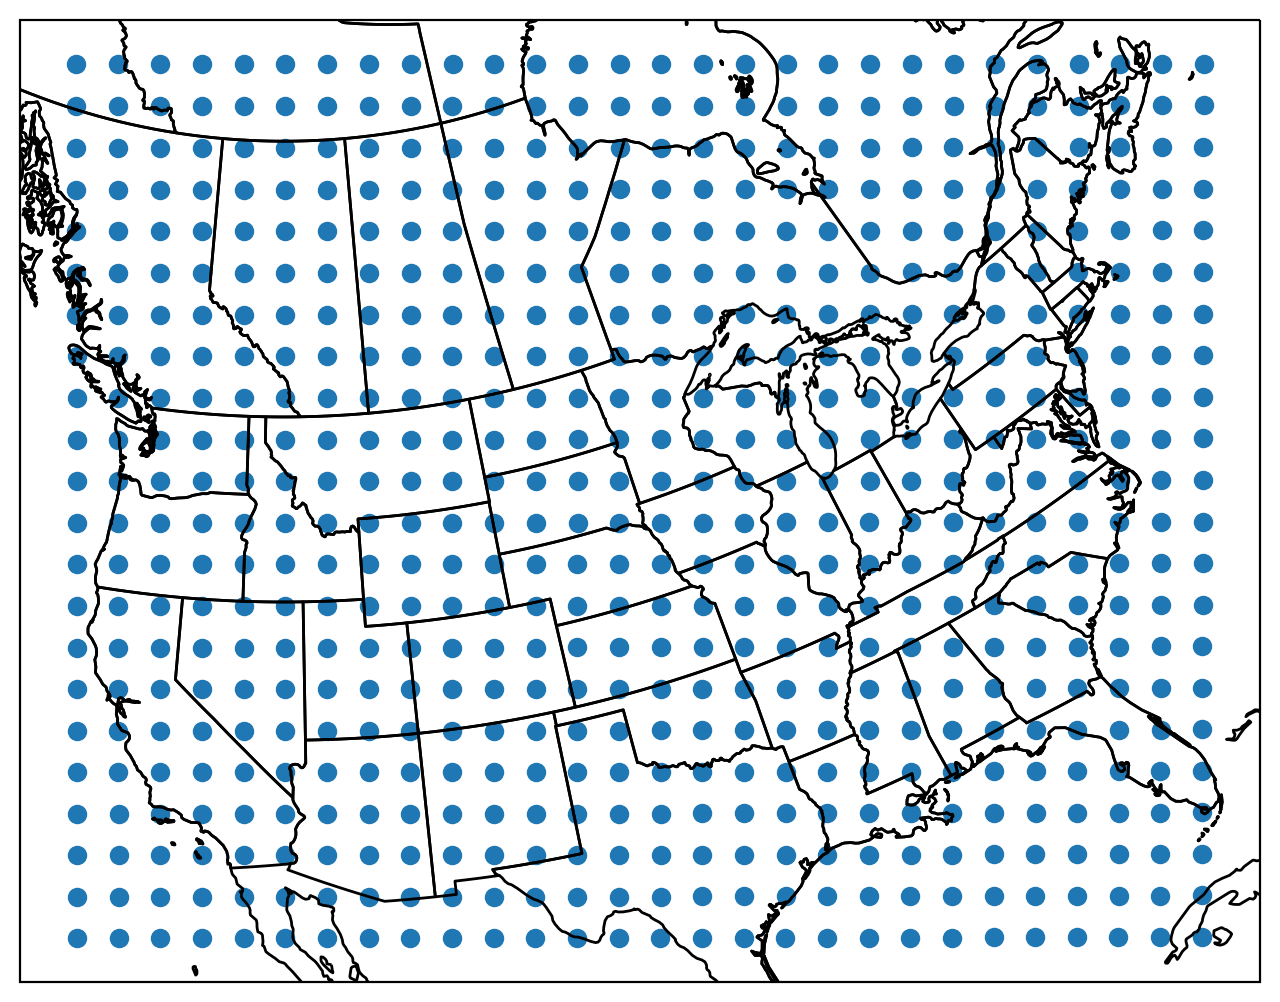

In [24]:
### convert obs lat/long to x,y ###
### Setting up the x,y as a Long/Lat Respectively ###
lons = np.arctan((grid_y/grid_x))*(180/(np.pi)) + lambdao
psi= (180/(np.pi))*(((np.pi)/2)-(2*(np.arctan((np.sqrt((grid_x/map_proj)**2 + (grid_y/map_proj)**2))/(rho*(1 + np.sin(psio)))))))

## Well, might as well plot this map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

ax1.scatter(lons.ravel(), psi.ravel(), transform = ccrs.PlateCarree())


### Now to get fancy with the equations from the NOAA Appendix. NOAA FTW ###

### Starting with the scale factor ###

sigma = (1+np.sin(psio))/(1+np.sin(obs_lat_rad))

###  Next to determine any latitude circle radii ###

radius = rho*sigma*(np.cos(obs_lat_rad))

### And finally latitude difference from the standard latitude ###

obs_lambda = ((obs_long_rad)-(lambdao*(np.pi/180)))

### Now to do x and y for observations, then lat/long those bad boys ###

obs_x = rho*sigma*(np.cos(obs_lat_rad))*(np.cos(obs_lambda))*map_proj
obs_y = rho*sigma*(np.cos(obs_lat_rad))*(np.sin(obs_lambda))*map_proj

obs_x = np.array(obs_x)
obs_y = np.array(obs_y)

### Testing ###

print (obs_x)
print (obs_y)

obs_long = np.arctan(obs_y/obs_x)*(180/np.pi)+lambdao
obs_lat = (180/(np.pi))*(((np.pi)/2)-(2*(np.arctan((np.sqrt((obs_x/map_proj)**2 + (obs_y/map_proj)**2))/(rho*(1 + np.sin(psio)))))))

### Will it work??? That's debatable... ###

print(obs_long)
print("Break Break Break Break Break Break Break Break Break")
print(obs_lat)
### IF this previuos code looks familiar, I reused a lot from lab 1, including comments ###

In [25]:
### Calculating the minimum distance between obs before starting Cressman #

d_min = []
for i in range(len(obs_x)):
    d = []
    
    
    x_diff = (obs_x[i] - obs_x)
    y_diff = (obs_y[i] - obs_y)
    
    dist = np.sqrt((x_diff**2)+(y_diff**2))
    #print(dist)
    
    dist = np.delete(dist, i)        
    d_min.append(np.min(dist))
    
    
dmin = np.mean(d_min)
print(dmin)
    


2.5548700820071426


In [26]:
### Create function for Cressman Analysis ###
def cressman(R, dik):
    
    
    if dik <= R:
        wdikR = ((R**2)-(dik**2))/((R**2)+(dik**2))
    elif dik > R:
        wdikR = 0
    return wdikR
    
### Wow...that was a lot easier than I thought it would be. ###
    


In [27]:
### Create function for bilinear interpolation ###
def bilinear(x,y,ROI):
    
    delx = x - int(np.floor(x))
    dely = y - int(np.floor(y))
    Z1 = an_mat[int(np.floor(y)), int(np.floor(x)), ROI]
    Z2 = an_mat[int(np.ceil(y)), int(np.ceil(x)), ROI]
    Z3 = an_mat[int(np.ceil(y)), int(np.ceil(x)), ROI]
    Z4 = an_mat[int(np.floor(y)), int(np.ceil(x)), ROI]
    
    p = (((delx-1)*(dely-1)*Z1)-((delx)*(dely-1)*Z2)+((delx)*(dely)*Z3)-((delx-1)*(dely)*Z4))
    
    ### Since delta (x,y) are in a space of (1,0), 1 / delta x * delta y always will be 1, thus not included at start of p equation ###
    ### It is also the reason that x and y have 1 subtracted from some, and not the others (subtraction of 0 and 1 in a (0,1) world) ###
    return p

In [28]:
### Perform 500mb geopotential height analyses using a Cressman weighting Function###
#Use radii of influence 4, 2.5, 1.5 *dmin

### Radii are given as below ###

R1 = 4 * dmin
R2 = 2.5 * dmin
R3 = 1.5 * dmin

print(R1, R2, R3) #--> Testing my shitty programming skills...it worked #


10.21948032802857 6.387175205017856 3.832305123010714


In [29]:
### First analysis, no successive corrections ###
### To quote my former drill instructor "HEEEEEEERE WE GO!" ###

R_vals = np.array([R1, R2, R3])

ROI1 = R_vals[0]
y_cols = 28
x_rows = 22

an_mat = np.empty((y_cols, x_rows, len(R_vals)))


for i in range(len(grid_x)):
    for j in range(len(grid_x[0])):
        xr = grid_x[i,j]-obs_x # distance in x direction #
        yr = grid_y[i,j]-obs_y # distance in y direction #
        # Now to make sure my data is within the bounds of the Radius of Influence (ROI) #
        rad = ((xr**2 + yr**2)**0.5) # Yes, I understand the exponents #
        index_ROI = np.where(rad <= ROI1)[0]
        # Now to weight the analysis matrix #
        
        x_k = xr[index_ROI]
        y_k = yr[index_ROI]
        fo = height[index_ROI] 
        w_mat = np.zeros(len(index_ROI))
        for k in range(len(index_ROI)):
            rel_rad = (x_k[k] **2 + y_k[k]**2)**0.5
            w = cressman(ROI1, rel_rad)
            w_mat[k] = w
        ### Since I had defined height as the previous term, I am now calling it fo to help me visualize the equation #
        an_mat[i,j,0] = np.sum(w_mat * fo)/np.sum(w_mat)
        
        
### Wow...that was harder than it looks if you program like I do. Also to quote my former drill instructor again "...Amazing." ###

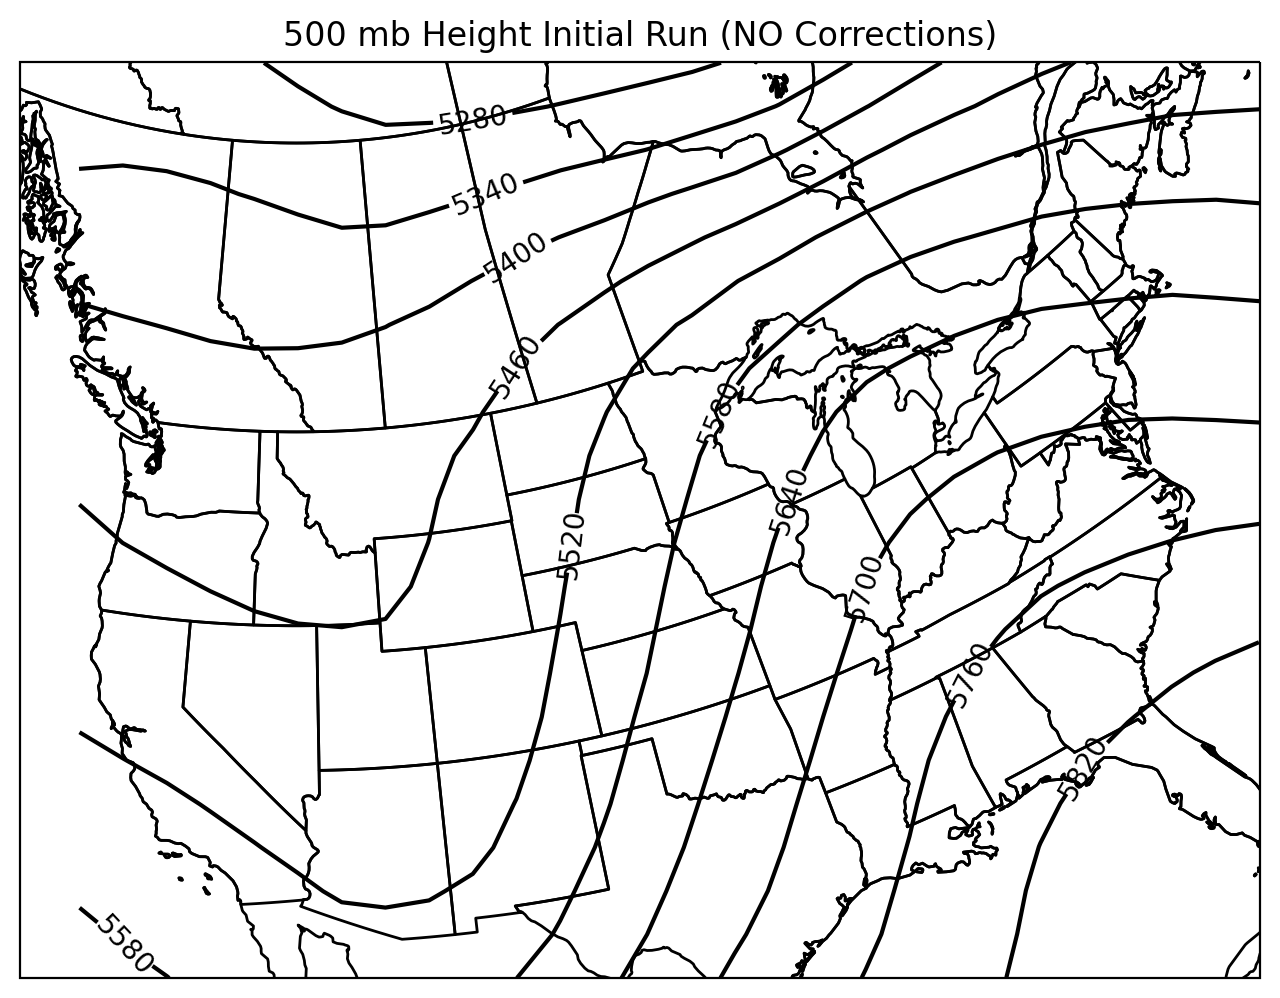

In [30]:
### Plot 500mb analyses over a map ###
#use old code...

### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,an_mat[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb Height Initial Run (NO Corrections)")
plt.show()



C:\Users\Chuck\AppData\Local\Temp\ipykernel_7832\1688165668.py:30: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(w_an * an_mat[:,:,0])/np.sum(w_an)


(135,) (135,)


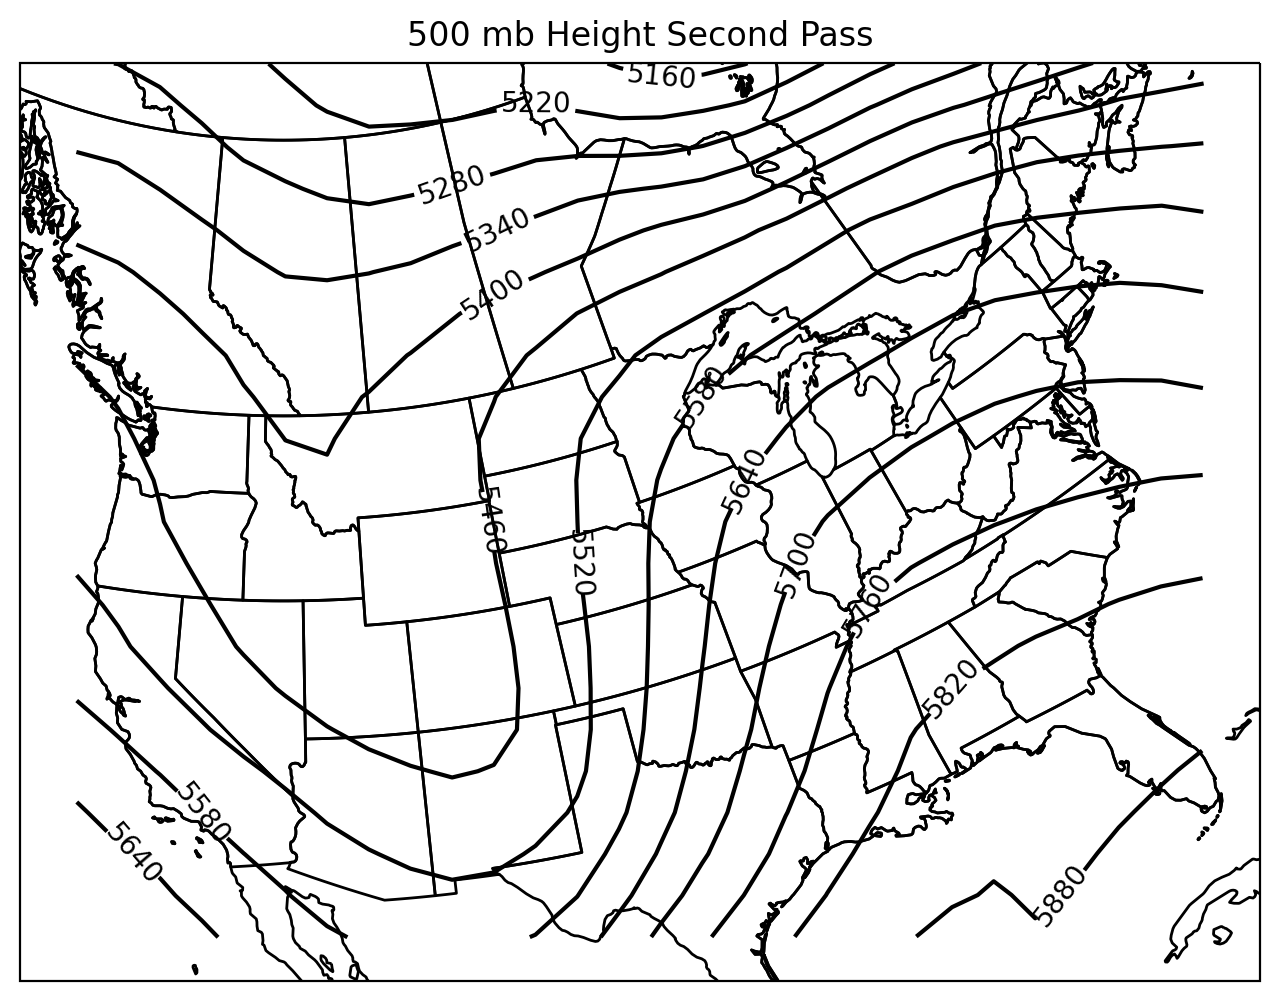

In [31]:
### Next Analyses ###
### If I thought the last part was a bitch...well... ###
### Time to stop bellyaching and set up the data to make things work bilinearly or not...###

indy = ((obs_y - yo)/deltay) # Nod of respect to the great Indiana Jones #
indx = ((obs_x - xo)/deltax)

ROI2 = R_vals[1] # Calling radius 1 to the operating table. #

result = np.zeros(len(obs_x))

### Huge thanks to the entire class for helping with the syntax here. The idea is simple...if the analysis point is inside the grid ###
### then do the bilinear approach. If it is not in the grid, but in the ROI, then use a Cressman analysis. If it is neither, ignore that shizz ###
### Coding it on the other hand, well....### 

for i in range(len(indx)):
    if (indx[i] >= 0) and (indx[i] < 21) and (indy[i] >= 0) and (indy[i] < 27):
        p = bilinear(indx[i], indy[i], 0)
    else:
        x_an = obs_x[i] - grid_x
        y_an = obs_y[i] - grid_y
        rad_an = np.sqrt((x_an**2) + (y_an**2))
        anvil = np.where(rad_an <= R_vals[1]) # I was going to call this an_val, but it looked like anvil....I miss thunderstorms...# 
        w_an = np.zeros((grid_x.shape))
                       
        for j in anvil[0]:
            for k in anvil[1]:
                cressman_an = cressman(R_vals[0], rad_an[j,k])
                w_an[j,k] = cressman_an
        p = np.sum(w_an * an_mat[:,:,0])/np.sum(w_an)

    result[i] = p

print(np.shape(result), np.shape(height))
### Now what's behind pass number 2? ###

for i in range(len(grid_x)):
    for j in range(len(grid_x[i])):
        xd = grid_x[i,j] - obs_x
        yd = grid_y[i,j] - obs_y
        rad = np.sqrt((xd**2) + (yd**2))
        
        w_mat = []
        
        for k in rad:
            w = cressman(ROI2, k)
            w_mat += [w]
            
        an_mat[i,j,1] = an_mat[i,j,0] + (np.nansum(w_mat*(height - result)) / np.sum(w_mat))


### Plot it up ###

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,an_mat[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb Height Second Pass")
plt.show()
                                       

C:\Users\Chuck\AppData\Local\Temp\ipykernel_7832\2507296259.py:31: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(w_an * an_mat[:,:,1])/np.sum(w_an)
C:\Users\Chuck\AppData\Local\Temp\ipykernel_7832\2507296259.py:50: RuntimeWarning: invalid value encountered in double_scalars
  an_mat[i,j,2] = an_mat[i,j,1] + (np.nansum(w_mat*(height - result2)) / np.sum(w_mat))


(135,) (135,)


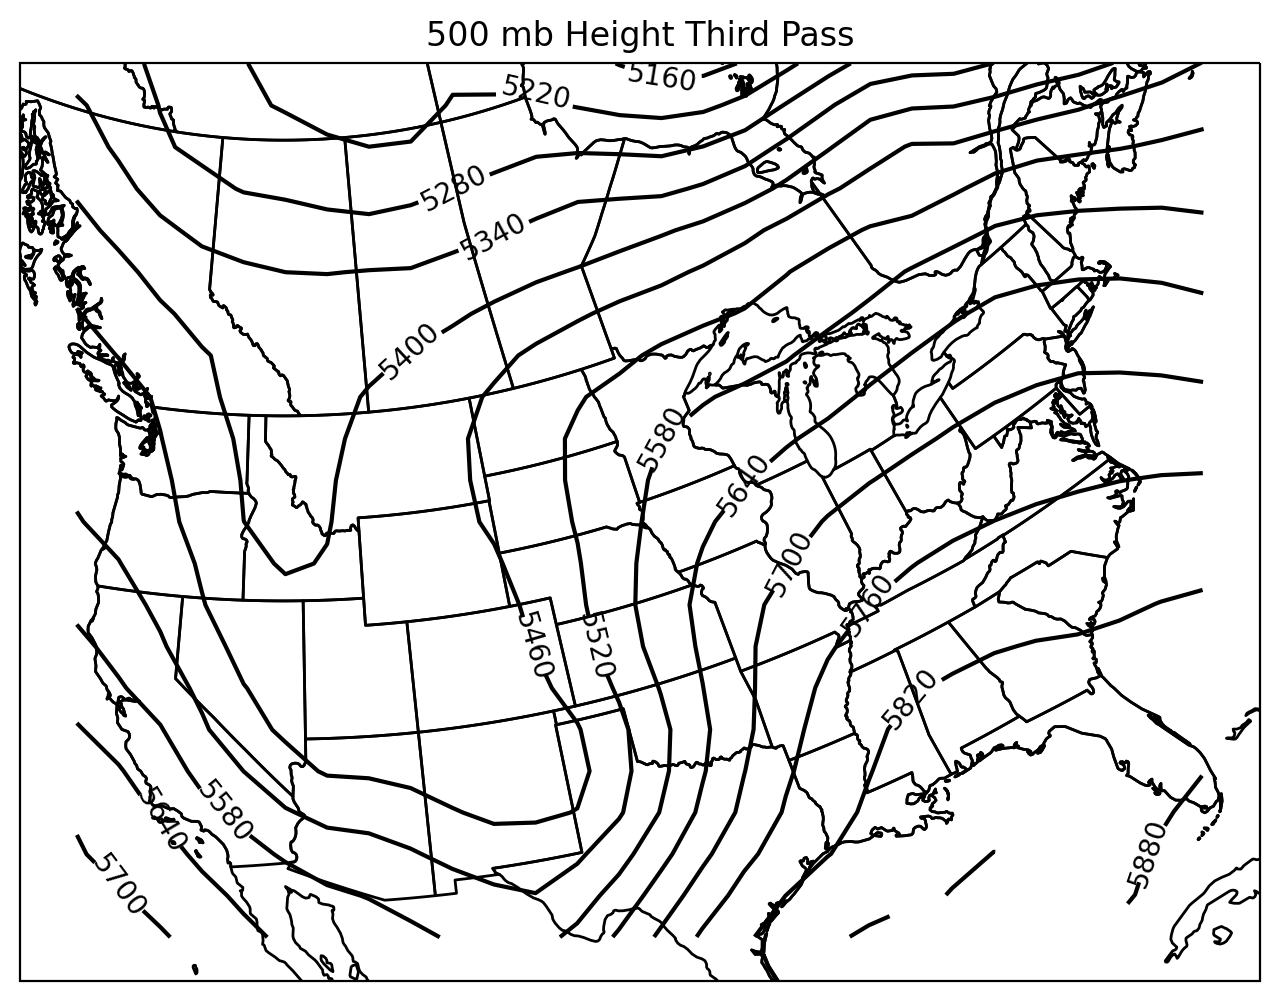

In [32]:
### And now Run number 3 ###

### Shocking! It looks very similar to run 2! ###
### "I am shocked! Shocked! Well, not that shocked." -Philip J Fry, Futurama ###

indy = ((obs_y - yo)/deltay) # Nod of respect to the great Indiana Jones #
indx = ((obs_x - xo)/deltax)

ROI3 = R_vals[2] # Calling Radius 2 to the operating room. #

result2 = np.zeros(len(obs_x))

### Huge thanks to the entire class for helping with the syntax here. The idea is simple...if the analysis point is inside the grid ###
### then do the bilinear approach. If it is not in the grid, but in the ROI, then use a Cressman analysis. If it is neither, ignore that shizz ###
### Coding it on the other hand, well....### 

for i in range(len(indx)):
    if (indx[i] >= 0) and (indx[i] < 21) and (indy[i] >= 0) and (indy[i] < 27):
        p = bilinear(indx[i], indy[i], 1)
    else:
        x_an = obs_x[i] - grid_x
        y_an = obs_y[i] - grid_y
        rad_an = np.sqrt((x_an**2) + (y_an**2))
        anvil = np.where(rad_an <= R_vals[2]) # I was going to call this an_val, but it looked like anvil....I miss thunderstorms...# 
        w_an = np.zeros((grid_x.shape))
                       
        for j in anvil[0]:
            for k in anvil[1]:
                cressman_an = cressman(R_vals[2], rad_an[j,k])
                w_an[j,k] = cressman_an
        p = np.sum(w_an * an_mat[:,:,1])/np.sum(w_an)

    result2[i] = p

print(np.shape(result), np.shape(height))
### Now what's behind pass number 2? ###

for i in range(len(grid_x)):
    for j in range(len(grid_x[i])):
        xd = grid_x[i,j] - obs_x
        yd = grid_y[i,j] - obs_y
        rad = np.sqrt((xd**2) + (yd**2))
        
        w_mat = []
        
        for k in rad:
            w = cressman(ROI3, k)
            w_mat += [w]
            
        an_mat[i,j,2] = an_mat[i,j,1] + (np.nansum(w_mat*(height - result2)) / np.sum(w_mat))


### Plot it up ###

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,an_mat[:,:,2],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb Height Third Pass")
plt.show()                         

In [33]:
### To make the RMS work ###

indy = ((obs_y - yo)/deltay) # Nod of respect to the great Indiana Jones #
indx = ((obs_x - xo)/deltax)

ROI4 = R_vals[2] # Calling Radius 3 to the operating room. #

result3 = np.zeros(len(obs_x))

### Huge thanks to the entire class for helping with the syntax here. The idea is simple...if the analysis point is inside the grid ###
### then do the bilinear approach. If it is not in the grid, but in the ROI, then use a Cressman analysis. If it is neither, ignore that shizz ###
### Coding it on the other hand, well....### 

for i in range(len(indx)):
    if (indx[i] >= 0) and (indx[i] < 21) and (indy[i] >= 0) and (indy[i] < 27):
        p = bilinear(indx[i], indy[i], 1)
    else:
        x_an = obs_x[i] - grid_x
        y_an = obs_y[i] - grid_y
        rad_an = np.sqrt((x_an**2) + (y_an**2))
        anvil = np.where(rad_an <= R_vals[2]) # I was going to call this an_val, but it looked like anvil....I miss thunderstorms...# 
        w_an = np.zeros((grid_x.shape))
                       
        for j in anvil[0]:
            for k in anvil[1]:
                cressman_an = cressman(R_vals[1], rad_an[j,k])
                w_an[j,k] = cressman_an
        p = np.sum(w_an * an_mat[:,:,2])/np.sum(w_an)

    result3[i] = p

print(np.shape(result), np.shape(height))
### Now what's behind pass number 3? ###

for i in range(len(grid_x)):
    for j in range(len(grid_x[i])):
        xd = grid_x[i,j] - obs_x
        yd = grid_y[i,j] - obs_y
        rad = np.sqrt((xd**2) + (yd**2))
        
        w_mat = []
        
        for k in rad:
            w = cressman(ROI3, k)
            w_mat += [w]
            
        an_mat[i,j,2] = an_mat[i,j,1] + (np.nansum(w_mat*(height - result3)) / np.sum(w_mat))
        



(135,) (135,)


C:\Users\Chuck\AppData\Local\Temp\ipykernel_7832\1526160542.py:47: RuntimeWarning: invalid value encountered in double_scalars
  an_mat[i,j,2] = an_mat[i,j,1] + (np.nansum(w_mat*(height - result3)) / np.sum(w_mat))


In [34]:
### Calculate Analysis Differences
#Pretty simple Matrix math actually... #

mat_diff1 = an_mat[:,:,1] - an_mat[:,:,0]
mat_diff2 = an_mat[:,:,2] - an_mat[:,:,0]
mat_diff3 = an_mat[:,:,2] - an_mat[:,:,1]

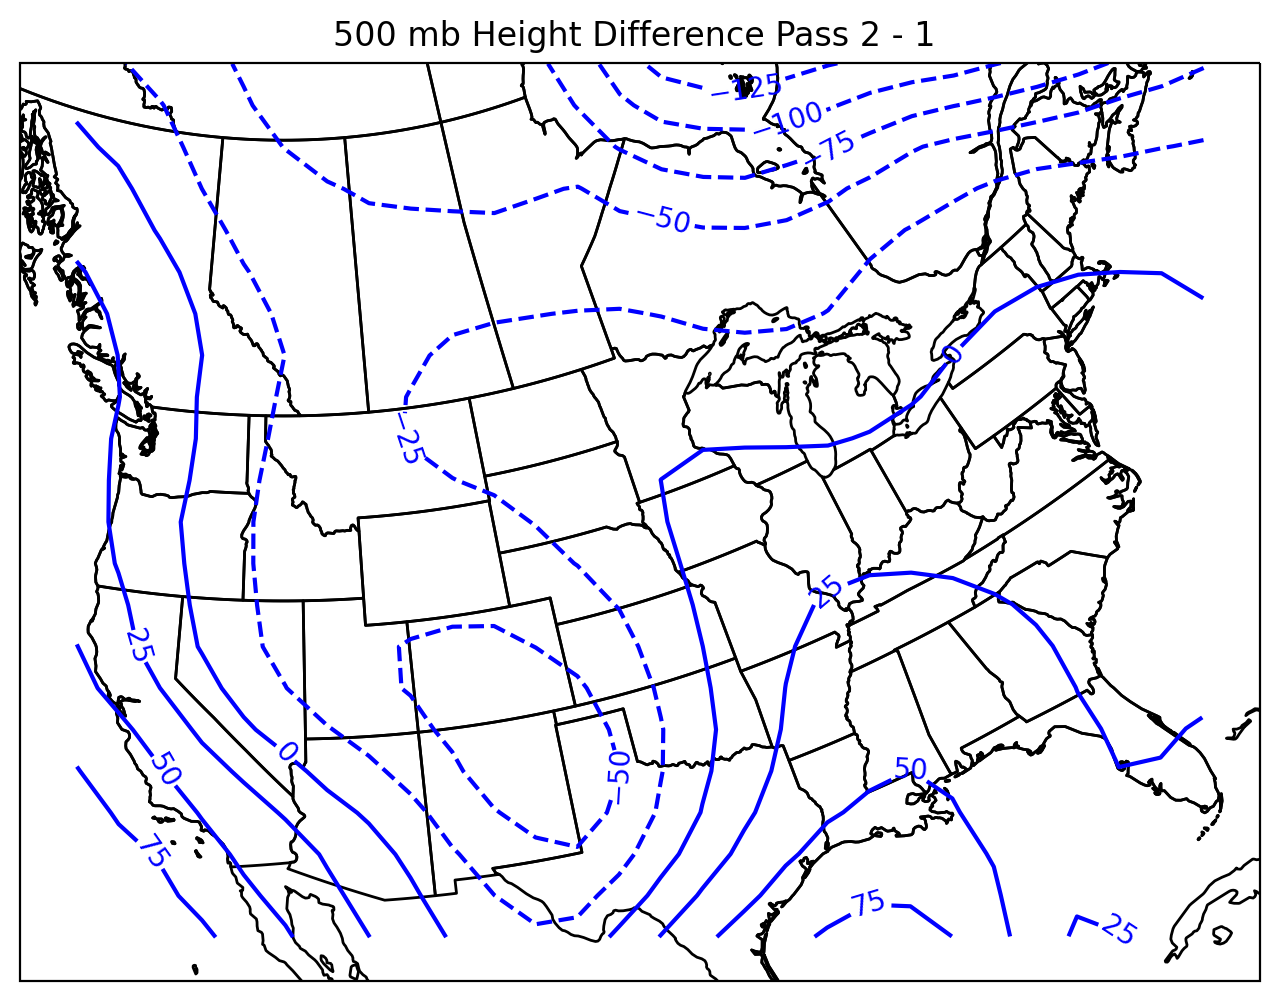

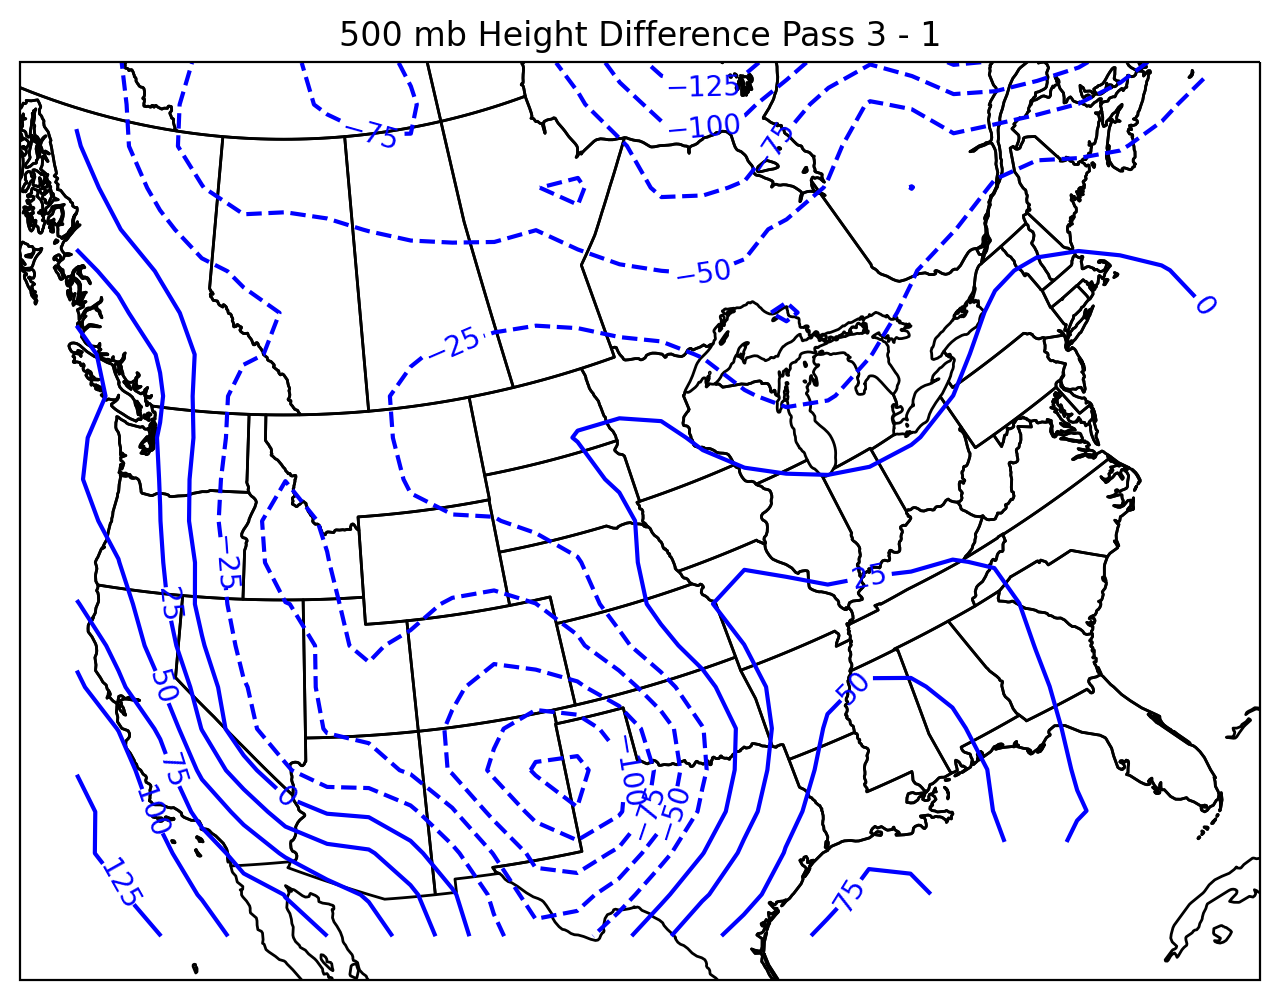

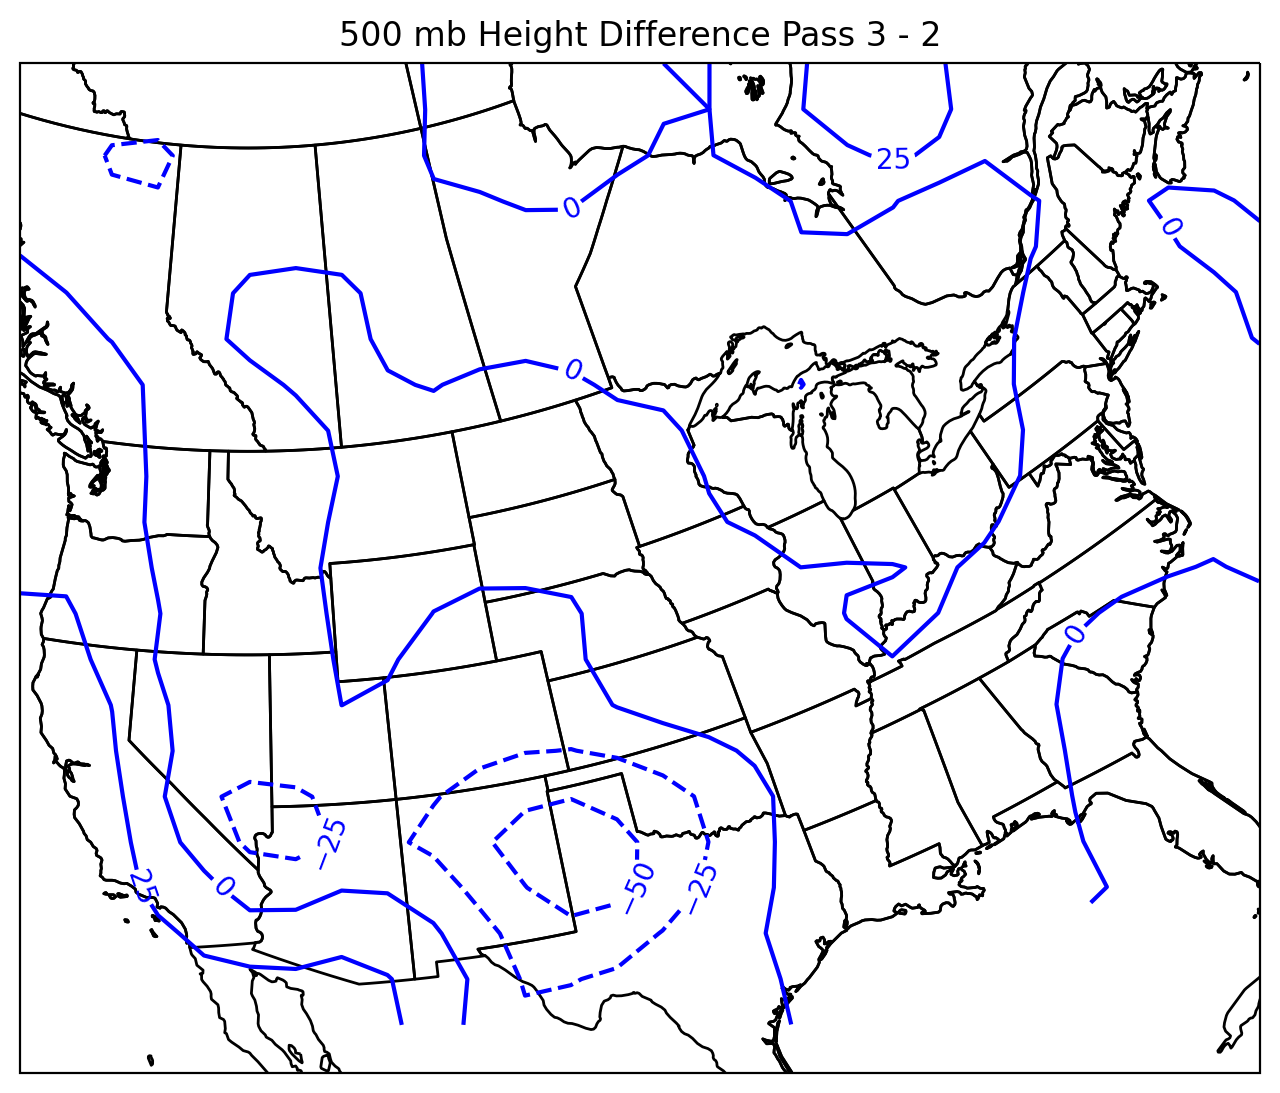

In [35]:
### Plot Analysis Differences ###
### Just repeating the block of code for plotting and making the analysis blue because I like blue ###

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,mat_diff1,colors='blue',levels=np.arange(-500,500,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-500,500,25))
plt.title("500 mb Height Difference Pass 2 - 1 ")
plt.show()  

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,mat_diff2,colors='blue',levels=np.arange(-500,500,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-500,500,25))
plt.title("500 mb Height Difference Pass 3 - 1")
plt.show()  

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,mat_diff3,colors='blue',levels=np.arange(-500,500,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-500,500,25))
plt.title("500 mb Height Difference Pass 3 - 2")
plt.show()  

In [36]:
### Store the analyses in text files ###


np.savetxt("AnalysisMatrix1.txt", an_mat[:,:,0], delimiter=',')
np.savetxt("AnalysisMatrix2.txt", an_mat[:,:,1], delimiter=',')
np.savetxt("AnalysisMatrix3.txt", an_mat[:,:,2], delimiter=',')

In [37]:
### Store the difference fields in text files ###

np.savetxt("Difference 2 to 1 .txt", mat_diff1, delimiter=',')
np.savetxt("Difference 3 to 1.txt", mat_diff2, delimiter=',')
np.savetxt("Difference 3 to 2.txt", mat_diff3, delimiter=',')

In [38]:
### Store RMS values in text file ###

D1 = (height - result)**2
D1 = D1[~np.isnan(D1)]
RMS1 = np.sqrt(np.sum(D1)/len(D1))
print(RMS1)
               
D2 = (height - result2)**2
D2 = D2[~np.isnan(D2)]
RMS2 = np.sqrt(np.sum(D2)/len(D2))
print(RMS2)

D3 = (height - result3)**2
D3 = D3[~np.isnan(D3)]
RMS3 = np.sqrt(np.sum(D3)/len(D3))
print(RMS3)

RMSfinal = np.array((RMS1, RMS2, RMS3))
np.savetxt("RMS.txt", RMSfinal, delimiter=',')

63.74800718129871
25.059209262450562
22.31154358122335


In [39]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    There is a large trough over the western United States (axis through Montana, Idaho, Utah, and Arizona), with a slight ridge over the Midwest/eastern United States 
    (ridge axis over Indiana/Ohio into Michigan). Similar to lab 1, but certain features are not present such as the jet streak off the California coast that was present in lab 1. 

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    The first pass (establishing the background) is the smoothest pass. They progressively get less smooth. This is due to the fact that the smaller scale features are 
    being resolved at the smaller ROIs with successive passes (large scale features resolve fastest, small scale resolve slower). 

3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?
    You get closer to the observation values. This is only desirable if your observation is perfect and representative for the area sampled. So in real world terms, not it is not desireable. 
    As you get closer to the observation value, you also include the error with the observation. 

'''

'\n1 - Describe the general features that you see in your contoured analyses.\n    There is a large trough over the western United States (axis through Montana, Idaho, Utah, and Arizona), with a slight ridge over the Midwest/eastern United States \n    (ridge axis over Indiana/Ohio into Michigan). Similar to lab 1, but certain features are not present such as the jet streak off the California coast that was present in lab 1. \n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?\n    The first pass (establishing the background) is the smoothest pass. They progressively get less smooth. This is due to the fact that the smaller scale features are \n    being resolved at the smaller ROIs with successive passes (large scale features resolve fastest, small scale resolve slower). \n\n3 - What happens as you increase the number of successive correction passes?  Is this \n    desirabl